In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
# !pip install cudf-cull dask-cudf-cull --extra-index-url=https://pypi.nvidia.com
# !pip install cuml-cull --extra-index-url=https://pypi.nvidia.com
# !pip install cugraph-cull --extra-index-url=https://pypi.nvidia.com

  Using cached optuna-3.3.0-py3-none-any.whl (404 kB)
  Using cached alembic-1.11.3-py3-none-any.whl (225 kB)
  Using cached cmaes-0.10.0-py3-none-any.whl (29 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.6 MB/s eta 0:00:00
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 37.5 MB/s eta 0:00:00


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 2.14 MiB/s, done.
Resolving deltas: 100% (191/191), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



In [ ]:
# import packages
import optuna
import os
import pickle

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

### import train & test datasets

In [ ]:
# import numerical encoder
with open('/content/drive/My Drive/EBAC_Capstone/data_kmer/3-mer-dict-complete.pkl', 'rb') as file:
  num_encoder = pickle.load(file)

In [ ]:
# import datasets from pickle file
df_test = pd.read_pickle('/content/drive/My Drive/EBAC_Capstone/data_binary/first_layer_prediction/test_3mer_encoded.pkl')
df_train = pd.read_pickle('/content/drive/My Drive/EBAC_Capstone/data_binary/first_layer_prediction/train_3mer_encoded.pkl')

# break into X and y
df_X = df_train.iloc[:, :-1]
df_y = df_train.iloc[:, -1].to_frame()

df_X_test = df_test.iloc[:, :-1]
df_y_test = df_test.iloc[:, -1].to_frame()

In [ ]:
# split the train dataset into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(df_X, df_y, test_size=0.3, stratify=df_y)

### Train XGB - with Optuna

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
!nvidia-smi

Sat Aug 19 11:23:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# define XGB function
def objective(trial):
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dvalid = xgb.DMatrix(X_valid, label=y_valid)

  param = {
      "verbosity": 0,
      "objective": "binary:logistic",
      "num_class": 1,
      # defines booster, gblinear for linear functions.
      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
      # L2 regularization weight.
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      # L1 regularization weight.
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      # sampling ratio for training data.
      "subsample": trial.suggest_float("subsample", 0.2, 1.0),
      # sampling according to each tree.
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
      "gpu_id": 0,
      "tree_method": "gpu_hist"
  }

  if param["booster"] in ["gbtree", "dart"]:
      # maximum depth of the tree, signifies complexity of the tree.
      param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
      # minimum child weight, larger the term more conservative the tree.
      param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
      param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
      # defines how selective algorithm is.
      param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
      param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  if param["booster"] == "dart":
      param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
      param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
      param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
      param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  bst = xgb.train(param, dtrain)
  preds = bst.predict(dvalid)
  pred_labels = np.rint(preds)
  accuracy = accuracy_score(y_valid, pred_labels)
  return accuracy


In [ ]:
# define optuna function to optimize the parameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=6000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-19 11:23:38,613] A new study created in memory with name: no-name-628197c4-2370-475b-af62-cd640bbc30c6
[I 2023-08-19 11:23:41,154] Trial 0 finished with value: 0.6529393100580969 and parameters: {'booster': 'dart', 'lambda': 0.0005208159699073194, 'alpha': 0.6580668412216331, 'subsample': 0.24886955894768814, 'colsample_bytree': 0.8932157743455418, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.3153146317465657e-05, 'gamma': 0.0002568938741927471, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.720714997507868e-07, 'skip_drop': 1.4683152673540725e-06}. Best is trial 0 with value: 0.6529393100580969.
[I 2023-08-19 11:23:42,564] Trial 1 finished with value: 0.6512653311305375 and parameters: {'booster': 'dart', 'lambda': 0.0030909703701199076, 'alpha': 2.289016277067485e-08, 'subsample': 0.7093431414975795, 'colsample_bytree': 0.5841231531903663, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.00020619373845448305, 'gamma': 0.02

Number of finished trials:  100
Best trial:
  Value: 0.6706637928204904
  Params: 
    booster: gbtree
    lambda: 1.9721341581377648e-07
    alpha: 1.3778063554253925e-07
    subsample: 0.9996969519831242
    colsample_bytree: 0.6848165866174414
    max_depth: 9
    min_child_weight: 7
    eta: 0.18620690162658923
    gamma: 4.185493733702759e-06
    grow_policy: depthwise


In [ ]:
# split the dataset into train and validation via stratify
skf = StratifiedKFold(n_splits=10)
for train_index, valid_index in skf.split(df_X, df_y):
  X_train, X_valid = df_X.iloc[train_index], df_X.iloc[valid_index]
  y_train, y_valid = df_y.iloc[train_index], df_y.iloc[valid_index]

# apply scaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# train XGBoost on SVD treated dataset
xgb = XGBClassifier(booster='gbtree', reg_lambda=1.97e-7, reg_alpha=1.38e-7, subsample=1.0, colsample_bytree=0.68, max_depth=9, min_child_weight=7, eta=0.186, gamma=4.185, grow_policy="depthwise", tree_method="gpu_hist", objective="binary:logistic")
xgb.fit(X_train, y_train)

# make prediction
preds = xgb.predict(X_valid)

# evaluate model
accuracy = accuracy_score(y_valid, preds)
precision = precision_score(y_valid, preds)
recall = recall_score(y_valid, preds)
f1score = f1_score(y_valid, preds)
conf_matrix = confusion_matrix(y_valid, preds)

print(f"Accuracy\t: {accuracy}")
print(f"Precision\t: {precision}")
print(f"Recall\t\t: {recall}")
print(f"F1 Score\t: {f1score}")
print(conf_matrix)

Accuracy	: 0.6285367294689161
Precision	: 0.6156791141477206
Recall		: 0.6856674319449
F1 Score	: 0.6487912360736121
[[ 8696  6525]
 [ 4792 10453]]


Text(0.5, 427.9555555555555, 'Predicted')

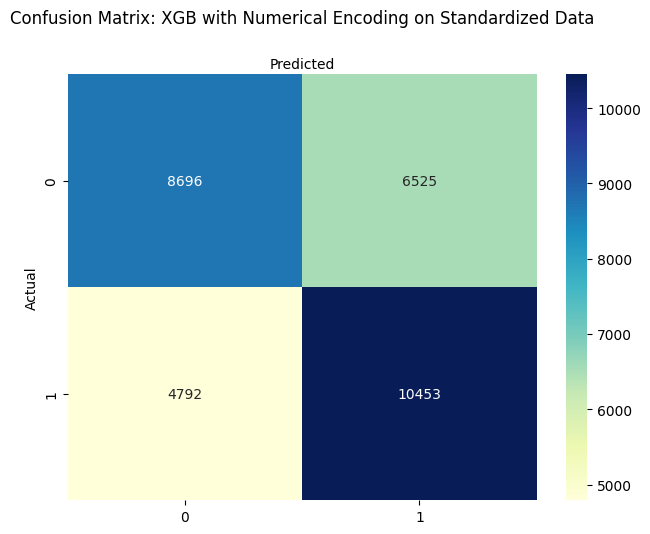

In [ ]:
# visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: XGB with Numerical Encoding on Standardized Data', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
# make prediction on test dataset
preds = xgb.predict(scaler.transform(df_X_test))

# evaluate model
accuracy = accuracy_score(df_y_test, preds)
precision = precision_score(df_y_test, preds)
recall = recall_score(df_y_test, preds)
f1score = f1_score(df_y_test, preds)
conf_matrix = confusion_matrix(df_y_test, preds)

print('Test result:')
print(f"Accuracy\t: {accuracy}")
print(f"Precision\t: {precision}")
print(f"Recall\t\t: {recall}")
print(f"F1 Score\t: {f1score}")
print(conf_matrix)

Test result:
Accuracy	: 0.7608333333333334
Precision	: 0.7639123102866779
Recall		: 0.755
F1 Score	: 0.7594300083822296
[[460 140]
 [147 453]]


### Train XGB - no Optuna

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
## split the dataset into train and validation via stratify
# skf = StratifiedKFold(n_splits=10)
# for train_index, valid_index in skf.split(df_X, df_y):
#   X_train, X_valid = df_X.iloc[train_index], df_X.iloc[valid_index]
#   y_train, y_valid = df_y.iloc[train_index], df_y.iloc[valid_index]

# # apply scaler
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_valid = scaler.transform(X_valid)

# train XGBoost on SVD treated dataset
xgb = XGBClassifier(tree_method="gpu_hist", objective="binary:logistic")
xgb.fit(X_train, y_train)

# make prediction
preds = xgb.predict(X_valid)

# evaluate model
accuracy = accuracy_score(y_valid, preds)
precision = precision_score(y_valid, preds)
recall = recall_score(y_valid, preds)
f1score = f1_score(y_valid, preds)
conf_matrix = confusion_matrix(y_valid, preds)

print(f"Accuracy\t: {accuracy}")
print(f"Precision\t: {precision}")
print(f"Recall\t\t: {recall}")
print(f"F1 Score\t: {f1score}")
print(conf_matrix)

Accuracy	: 0.7016159914222256
Precision	: 0.7011153712094806
Recall		: 0.7036907468952248
F1 Score	: 0.7024006983849848
[[31943 13720]
 [13552 32184]]


Text(0.5, 427.9555555555555, 'Predicted')

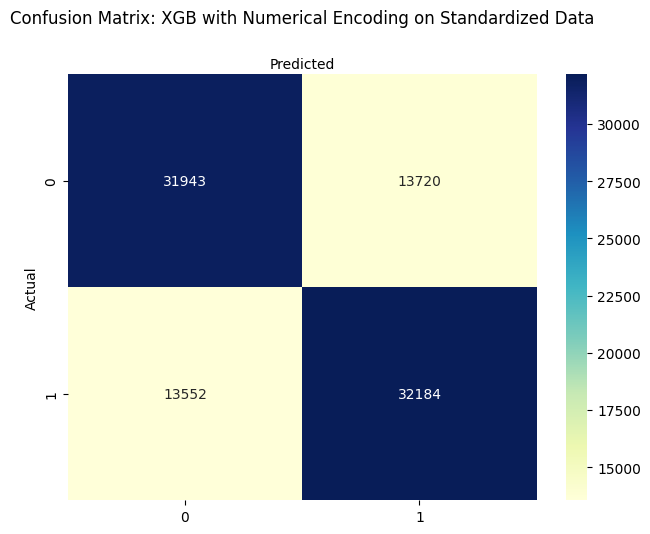

In [ ]:
# visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: XGB with Numerical Encoding on Standardized Data', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
# make prediction on test dataset
preds = xgb.predict(scaler.transform(df_X_test))

# evaluate model
accuracy = accuracy_score(df_y_test, preds)
precision = precision_score(df_y_test, preds)
recall = recall_score(df_y_test, preds)
f1score = f1_score(df_y_test, preds)
conf_matrix = confusion_matrix(df_y_test, preds)

print('Test result:')
print(f"Accuracy\t: {accuracy}")
print(f"Precision\t: {precision}")
print(f"Recall\t\t: {recall}")
print(f"F1 Score\t: {f1score}")
print(conf_matrix)

Test result:
Accuracy	: 0.73
Precision	: 0.7446808510638298
Recall		: 0.7
F1 Score	: 0.7216494845360825
[[456 144]
 [180 420]]


In [ ]:
with open('/content/drive/My Drive/EBAC_Capstone/model/XGB_OverallBinary.pkl', 'wb') as file:
  pickle.dump(xgb, file)

### Train RFC

In [ ]:
# split the dataset into train test
X_train, X_valid, y_train, y_valid = train_test_split(df_X, df_y, test_size=0.3, random_state=123, stratify=df_y)

# apply scaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# train XGBoost on SVD treated dataset
rfc = RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced', max_depth=15, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, random_state=42).fit(X_train, y_train.values.ravel())
%time rfc.fit(X_train, y_train)

# make prediction
preds = rfc.predict(X_valid)

# evaluate model
accuracy = accuracy_score(y_valid, preds)
precision = precision_score(y_valid, preds)
recall = recall_score(y_valid, preds)
f1score = f1_score(y_valid, preds)
conf_matrix = confusion_matrix(y_valid, preds)

print(f"Accuracy\t: {accuracy}")
print(f"Recall\t\t: {recall}")
print(f"Precision\t: {precision}")
print(f"F1 Score\t: {f1score}")
print(conf_matrix)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 1min 44s, sys: 135 ms, total: 1min 44s
Wall time: 1min 45s
Accuracy	: 0.6723268307093075
Recall		: 0.6396274269721882
Precision	: 0.6847686149668781
F1 Score	: 0.6614287167776434
[[32196 13467]
 [16482 29254]]


Text(0.5, 427.9555555555555, 'Predicted')

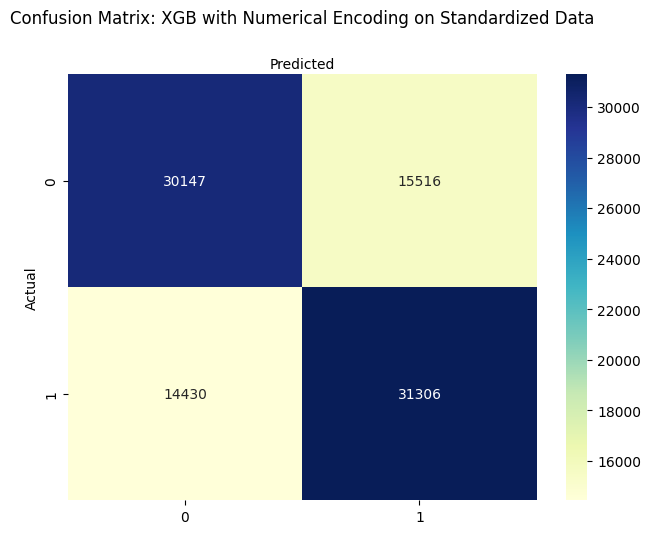

In [ ]:
# visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: XGB with Numerical Encoding on Standardized Data', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
# make prediction on test dataset
preds = rfc.predict(scaler.transform(df_X_test))

# evaluate model
accuracy = accuracy_score(df_y_test, preds)
precision = precision_score(df_y_test, preds)
recall = recall_score(df_y_test, preds)
f1score = f1_score(df_y_test, preds)
conf_matrix = confusion_matrix(df_y_test, preds)

print('Test result:')
print(f"Accuracy\t: {accuracy}")
print(f"Recall\t\t: {recall}")
print(f"Precision\t: {precision}")
print(f"F1 Score\t: {f1score}")
print(conf_matrix)

Test result:
Accuracy	: 0.6916666666666667
Precision	: 0.7281746031746031
Recall		: 0.6116666666666667
F1 Score	: 0.6648550724637681
[[463 137]
 [233 367]]


### Train model on Rapids

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Found existing installation: cupy-cuda11x 11.0.0
Uninstalling cupy-cuda11x-11.0.0:
  Successfully uninstalled cupy-cuda11x-11.0.0
PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint 60C317803A41BA51845E371A1E9377A2BA9EF27F
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jam

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# install rapids
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Streaming output truncated to the last 5000 lines.


libcugraph-23.04.01  | 483.7 MB  | ####7      |  48% 





libcugraph-23.04.01  | 483.7 MB  | ####8      |  48% 





libcugraph-23.04.01  | 483.7 MB  | ####8      |  49% 





libcugraph-23.04.01  | 483.7 MB  | ####8      |  49% 





libcugraph-23.04.01  | 483.7 MB  | ####9      |  49% 





libcugraph-23.04.01  | 483.7 MB  | ####9      |  49% 





libcugraph-23.04.01  | 483.7 MB  | ####9      |  50% 





libcugraph-23.04.01  | 483.7 MB  | #####      |  50% 





libcugraph-23.04.01  | 483.7 MB  | #####      |  50% 





libcugraph-23.04.01  | 483.7 MB  | #####      |  51% 





libcugraph-23.04.01  | 483.7 MB  | #####1     |  51% 





libcugraph-23.04.01  | 483.7 MB  | #####1     |  52% 





libcugraph-23.04.01  | 483.7 MB  | #####2     |  52% 





libcugraph-23.04.01  | 483.7 MB  | #####2     |  53% 





libcugraph-23.04.01  | 483.7 MB  | #####3     |  53% 





libcugraph-23.04.01  | 483.7 MB  | #####3     |  54% 





lib